In [1]:
!pip3 install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# centralized_training.py
import argparse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision import datasets, transforms
from torch.optim import Adam
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from collections import OrderedDict
import numpy as np
import torch.nn.functional as F
import random

import torchvision.models as models # ResNet-18

NUM_CLASSES = 26 #10

import sys
import os

from sklearn.neighbors import KNeighborsClassifier

def parse_args(dataset, model, epochs, batch_size=32, learning_rate=0.001, output_csv="results.csv"):
    args = {
        "dataset": dataset,
        "model": model,
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "output_csv": output_csv,
    }
    return args

from PIL import Image
from torch.utils.data import Dataset
'''
# Para uso no Google Colab
import resource

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/scripts')

db = '/content/drive/My Drive/np_load/'
'''

from tqdm import tqdm
import time

# Definição da classe Dataset para utilização com o MaleVis
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Inicializa o dataset.

        :param root_dir: Diretório onde as imagens estão armazenadas.
        :param transform: Transformações que serão aplicadas nas imagens.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_labels = []

        for label_dir in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_dir)
            if os.path.isdir(label_path):
                for img_name in os.listdir(label_path):
                    if img_name.endswith(".jpg") or img_name.endswith(".png"):
                        self.img_labels.append((os.path.join(label_path, img_name), label_dir))  # Caminho da imagem e rótulo

    def __len__(self):
        """Retorna o número total de amostras no dataset."""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Retorna uma amostra (imagem, rótulo) no índice fornecido.

        :param idx: Índice da amostra
        :return: A imagem e o rótulo (como tensor)
        """
        img_path, label = self.img_labels[idx]
        
        # Carrega a imagem
        image = Image.open(img_path)  
        
        # Dicionário de classes
        label_mapping = {'Vilsel': 0, 'Androm': 1, 'Snarasite': 2, 'MultiPlug': 3, 'Hlux': 4,'VBA': 5, 'Regrun': 6, 'Injector': 7, 'BrowseFox': 8, 'Fasong': 9, 'Allaple': 10, 'Agent': 11, 'Amonetize': 12, 'Other': 13, 'VBKrypt': 14,'HackKMS': 15, 'Dinwod': 16, 'Adposhel': 17, 'Neshta': 18, 'Autorun': 19,'InstallCore': 20, 'Sality': 21, 'Neoreklami': 22, 'Stantinko': 23, 'Elex': 24,'Expiro': 25}
        try:
            label = label_mapping[label]
        except KeyError:
            print(f"Warning: Label '{label}' not found in mapping. Skipping this sample.")
            return None

        if self.transform:
            image = self.transform(image)

        return image, label


In [3]:
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

def apply_transforms():
    return Compose([
        Resize((64, 64)),  # Redimensiona a imagem para 64x64
        ToTensor(),          # Converte a imagem para um tensor
        transforms.Grayscale(), # Converte para escala de cinza
        #transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Replica o canal de escala de cinza 3 vezes
        Normalize((0.1307,), (0.3081,))  # Normaliza a imagem com média e desvio padrão fornecidos
    ])


#def apply_transforms():
#    return Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

def get_data_loaders(dataset, batch_size):
    if dataset == "mnist":
        train_dataset = datasets.MNIST(root="../db", train=True, download=True, transform=apply_transforms())
        test_dataset = datasets.MNIST(root="../db", train=False, download=True, transform=apply_transforms())
    elif dataset == "fmnist":
        train_dataset = datasets.FashionMNIST(root="../db", train=True, download=True, transform=apply_transforms())
        test_dataset = datasets.FashionMNIST(root="../db", train=False, download=True, transform=apply_transforms())
    elif dataset == "cifar10":
        train_dataset = datasets.CIFAR10(root="../db", train=True, download=True, transform=apply_transforms())
        test_dataset = datasets.CIFAR10(root="../db", train=False, download=True, transform=apply_transforms())
    elif dataset == "custom":
        data_dir = "../db/"
        #data_dir = "/content/drive/My Drive/malevis/"
        #train_dataset = CustomDataset(root_dir=os.path.join(data_dir, "malevis_train"), transform=apply_transforms())
        #test_dataset = CustomDataset(root_dir=os.path.join(data_dir, "malevis_val"), transform=apply_transforms())
        train_dataset = CustomDataset(root_dir=os.path.join(data_dir, "reduced_train"), transform=apply_transforms())
        test_dataset = CustomDataset(root_dir=os.path.join(data_dir, "reduced_test"), transform=apply_transforms())

        
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [4]:
class TwoNN(nn.Module):
    def __init__(self, emb_dim):
        super(TwoNN, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(64*64, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 200),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(nn.Linear(200, emb_dim), nn.ReLU())
        self.emb_dim = emb_dim

    def need_all_features(self):
        return

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)#start_dim=1
        x = self.classifier(self.base(x))
        return x

In [5]:
# Example usage in a Jupyter notebook:
args = parse_args(
    dataset="custom",#"fmnist", custom
    model="mobilenetv2",#"twoNN",#"resnet18", "efficientnet-b0", "mobilenetv2",
    epochs=10,
    batch_size=128,
    learning_rate=0.01,
    output_csv="results.csv"
)

print(args)

{'dataset': 'custom', 'model': 'mobilenetv2', 'epochs': 10, 'batch_size': 128, 'learning_rate': 0.01, 'output_csv': 'results.csv'}


In [6]:
# Prototypical Center Loss function
class PrototypicalCenterLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin=2.0):
        """
        Prototypical center loss to minimize intra-class distance and maximize inter-class distance.

        :param num_classes: The number of distinct classes.
        :param embedding_size: The dimension of the embedding space.
        :param margin: A margin to separate class centers.
        """
        super(PrototypicalCenterLoss, self).__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin

        # Initialize class prototypes (centers) as learnable parameters
        self.prototypes = nn.Parameter(torch.randn(num_classes, embedding_size), requires_grad=True)

    def forward(self, embeddings, labels):
        """
        Compute prototypical center loss.

        :param embeddings: The input embeddings of shape [batch_size, embedding_dim].
        :param labels: The corresponding labels of shape [batch_size].
        :return: The prototypical center loss.
        """
        batch_size = embeddings.size(0)

        # Compute distance to the corresponding class prototype (center)
        dist_to_center = torch.norm(embeddings - self.prototypes[labels], dim=1)

        # Intra-class loss (minimize distance to the correct class prototype)
        loss_intra = torch.mean(torch.pow(dist_to_center, 2))

        # Optionally, add inter-class loss (encourage prototypes to be apart)
        inter_class_distances = torch.cdist(self.prototypes, self.prototypes)
        inter_class_distances = inter_class_distances + torch.eye(self.num_classes, device=embeddings.device) * 1e12  # Prevent self-comparison

        # Apply margin: penalize if prototypes are closer than the margin
        loss_inter = torch.mean(F.relu(self.margin - inter_class_distances))

        total_loss = loss_intra + loss_inter
        return total_loss


# Modify the pretrain function to use prototypical center loss
def pretrain_model_prototypical_center(encoder, dataloader, criterion, optimizer, num_epochs, device):
    encoder.train()  # Set the encoder to training mode

    for epoch in range(num_epochs):
        print(f"Iniciando época {epoch + 1}") # Para barra de progresso
        running_loss = 0.0
        for batch_data, batch_labels in tqdm(dataloader, desc=f'Época {epoch + 1}', unit='batch'):
            #batch_data = batch_data.view(batch_data.size(0), -1).to(device)
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass: compute embeddings
            embeddings = encoder(batch_data.float())

            # Compute prototypical center loss
            loss = criterion(embeddings, batch_labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Pretrain Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

def generate_pairs(X, Y, N):
    # Ensure N is even
    if N % 2 != 0:
        raise ValueError("N must be an even number.")

    num_same_label_pairs = N // 2
    num_different_label_pairs = N // 2

    # Precompute label indices
    label_to_indices = {label.item(): (Y == label).nonzero(as_tuple=True)[0].tolist() for label in torch.unique(Y)}

    X1, X2, labels = [], [], []

    # Generate similar pairs (same label)
    for _ in range(num_same_label_pairs):
        # Sample a label that has more than one instance
         while True:
           sampled_label = random.choice(list(label_to_indices.keys()))
           indices = label_to_indices[sampled_label]
           if len(indices) > 1:
                # Randomly sample two distinct indices for the same label
                idx1, idx2 = random.sample(indices, 2)
                X1.append(X[idx1])
                X2.append(X[idx2])
                labels.append(1)  # Similar pair label
                # Ensure the label has more than one element
                break


    # Generate dissimilar pairs (different labels)
    for _ in range(num_different_label_pairs):
        # Sample two different labels
        while len(list(label_to_indices.keys())) >= 2:

            label1, label2 = random.sample(list(label_to_indices.keys()), 2)
            idx1 = random.choice(label_to_indices[label1])
            idx2 = random.choice(label_to_indices[label2])
            # Directly add the dissimilar pairs
            X1.append(X[idx1])
            X2.append(X[idx2])
            labels.append(0)  # Dissimilar pair label
            break

    # Convert lists to tensors efficiently in one go
    X1 = torch.stack(X1)
    X2 = torch.stack(X2)
    labels = torch.tensor(labels)

    return X1, X2, labels

# Training loop with dynamic learning rate adjustment
def train_model_with_dynamic_lr(model, criterion, optimizer, train_loader, num_epochs, device, frozen = False):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Reduce LR by 0.5 every 50 epochs

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        #print(criterion.similar_prototypes, criterion.dissimilar_prototypes)

        #for batch_data, batch_labels in train_loader:
        for batch_data, batch_labels in tqdm(train_loader, desc=f'Época {epoch + 1}', unit='batch'):
            #batch_data = batch_data.view(batch_data.size(0), -1).to(device)
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            # Create pairs of samples and labels (1 for similar, 0 for dissimilar)
            #pairs, labels = create_pairs(batch_data, batch_labels)
            if True:
              pairs_1, pairs_2, labels = generate_pairs(batch_data, batch_labels, 200)
              pairs_1, pairs_2, labels = pairs_1.to(device), pairs_2.to(device), labels.to(device)

              # Compute embeddings using the frozen encoder
              if frozen:
                with torch.no_grad():
                    # Compute embeddings for both elements of the pairs
                    embeddings_x1 = model(pairs_1.float())
                    embeddings_x2 = model(pairs_2.float())
                    criterion.toggle_requires_grad(requires_grad_value = False)

              else:
                # Compute embeddings for both elements of the pairs
                embeddings_x1 = model(pairs_1.float())
                embeddings_x2 = model(pairs_2.float())
                criterion.toggle_requires_grad(requires_grad_value = True)

              # Compute loss
              loss = criterion(embeddings_x1, embeddings_x2, labels)

              # Backpropagation and optimization

              loss.backward()
              optimizer.step()

              running_loss += loss.item()

            #except:
            # pass

        scheduler.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')



In [7]:
class LearnablePrototypicalLossWithDiversityRegularization(nn.Module):
    def __init__(self, embedding_dim, num_similar_prototypes, num_dissimilar_prototypes, margin=1.0, lambda_reg=0.01):
        """
        Initialize the Prototypical Loss function with diversity regularization.
        paper : A New Similarity Space Tailored for Supervised Deep Metric Learning

        :param embedding_dim: The dimension of the input embeddings.
        :param num_similar_prototypes: Number of prototypical vectors for similar pairs.
        :param num_dissimilar_prototypes: Number of prototypical vectors for dissimilar pairs.
        :param margin: The minimum distance margin between prototypes.
        :param lambda_reg: Regularization strength.
        """
        super(LearnablePrototypicalLossWithDiversityRegularization, self).__init__()


        self.similar_prototypes = nn.Parameter(torch.cat((torch.zeros(1, embedding_dim), torch.randn(num_similar_prototypes-1, embedding_dim)), dim=0), requires_grad=True)
        self.dissimilar_prototypes = nn.Parameter(torch.randn(num_dissimilar_prototypes, embedding_dim) + 2.0, requires_grad=True)
        self.margin = margin
        self.lambda_reg = lambda_reg

    def toggle_requires_grad(self, index = 0, requires_grad_value = True):
        """
        Function to toggle requires_grad for specific vectors in self.similar_prototypes
        """
        # Detach the tensor first to prevent in-place modification errors
        with torch.no_grad():
            # Set the requires_grad for a specific vector at index
            self.similar_prototypes.data[index] = self.similar_prototypes.data[index].requires_grad_(requires_grad_value)
            self.dissimilar_prototypes.data[index] = self.dissimilar_prototypes.data[index].requires_grad_(requires_grad_value)


    def diversity_regularization(self, prototypes):
        """
        Computes the diversity regularization term to prevent prototypes from collapsing.
        Encourages all prototypes to be at least `margin` distance apart.

        :param prototypes: The prototypical vectors (similar or dissimilar).
        :return: A scalar representing the regularization loss.
        """
        num_prototypes = prototypes.size(0)
        reg_loss = 0.0

        for i in range(num_prototypes):
            for j in range(i + 1, num_prototypes):
                # Compute the Euclidean distance between prototype i and j
                dist = torch.norm(prototypes[i] - prototypes[j])

                # Penalize if the distance is less than the margin
                if dist < self.margin:
                    reg_loss += torch.pow(self.margin - dist, 2)

        return reg_loss

    def forward(self, x1, x2, label):
        # Compute the absolute difference vector s_ij
        s_ij = torch.abs(x1 - x2)

        # Expand s_ij to compute distance to all prototypes
        s_ij = s_ij.unsqueeze(1)  # Shape: [batch_size, 1, embedding_dim]

        # Compute distances to all similar prototypes
        dist_to_similar_prototypes = torch.cdist(s_ij, self.similar_prototypes.unsqueeze(0), p=2).squeeze(1)
        dist_to_dissimilar_prototypes = torch.cdist(s_ij, self.dissimilar_prototypes.unsqueeze(0), p=2).squeeze(1)

        # Compute similarity scores using the given formula
        similarity_similar = torch.pow(1 + torch.pow(dist_to_similar_prototypes, 2), -1)
        similarity_dissimilar = torch.pow(1 + torch.pow(dist_to_dissimilar_prototypes, 2), -1)

        # Normalization step: Sum of similarities for each prototype set
        denom_similar = torch.sum(similarity_similar, dim=1, keepdim=True)
        denom_dissimilar = torch.sum(similarity_dissimilar, dim=1, keepdim=True)

        # Normalize similarity scores
        similarity_similar_normalized = (similarity_similar / (denom_similar + denom_dissimilar))
        similarity_dissimilar_normalized = (similarity_dissimilar / (denom_similar + denom_dissimilar))

        # Calculate the loss:
        # If label == 1 (similar), minimize distance to similar prototypes
        # If label == 0 (dissimilar), minimize distance to dissimilar prototypes
        loss = -torch.mean(label * torch.log(torch.sum(similarity_similar_normalized, dim=1)) + (1 - label) * torch.log(torch.sum(similarity_dissimilar_normalized, dim=1)))

        total_loss = loss

        ## Diversity regularization to avoid prototype collapse
        #diversity_loss_similar = self.diversity_regularization(self.similar_prototypes)
        #diversity_loss_dissimilar = self.diversity_regularization(self.dissimilar_prototypes)

        # Add diversity regularization to the total loss
        #total_loss += self.lambda_reg * (diversity_loss_similar + diversity_loss_dissimilar)

        return total_loss

    def compute_norms(self):
        # Compute norms for the similar prototypes
        similar_norms = torch.norm(self.similar_prototypes, dim=1)  # Compute L2 norm for each vector

        # Compute norms for the dissimilar prototypes
        dissimilar_norms = torch.norm(self.dissimilar_prototypes, dim=1)  # Compute L2 norm for each vector

        # Combine both norms into a single vector (you could return them separately too)
        #combined_norms = torch.cat((similar_norms, dissimilar_norms), dim=0)

        return similar_norms, dissimilar_norms

In [8]:
def knn_in_embedding_space(model, train_loader, test_loader, criterion, device, k=1, num_samples_for_pairs=200):
    model.eval()

    # Collect train embeddings and labels
    train_embeddings = []
    train_labels = []

    with torch.no_grad():
        for batch_data, batch_labels in train_loader:
            #batch_data = batch_data.view(batch_data.size(0), -1).to(device)
            batch_data = batch_data.to(device)
            embeddings = model(batch_data)
            train_embeddings.append(embeddings.cpu())
            train_labels.append(batch_labels)

    train_embeddings = torch.cat(train_embeddings).cpu().numpy()
    train_labels = torch.cat(train_labels).cpu().numpy()

    # Initialize the k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_embeddings, train_labels)

    # Store predictions, true labels, and loss values
    all_preds = []
    all_labels = []
    running_loss = 0.0
    total_batches = 0

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            #batch_data = batch_data.view(batch_data.size(0), -1).to(device)
            batch_data = batch_data.to(device)
            embeddings = model(batch_data).cpu().numpy()

            # Perform k-NN classification in embedding space
            predicted_labels = knn.predict(embeddings)

            # Store predictions and true labels
            all_preds.extend(predicted_labels)
            all_labels.extend(batch_labels.cpu().numpy())

            # Compute loss based on pairs in the test set
            try:
                # Generate pairs for loss computation
                pairs_1, pairs_2, labels = generate_pairs(batch_data, batch_labels, num_samples_for_pairs)
                pairs_1, pairs_2, labels = pairs_1.to(device), pairs_2.to(device), labels.to(device)

                # Compute embeddings for pairs
                embeddings_x1 = model(pairs_1)
                embeddings_x2 = model(pairs_2)

                # Compute loss
                loss = criterion(embeddings_x1, embeddings_x2, labels)
                running_loss += loss
                total_batches += 1
            except Exception as e:
                print(f"Error generating pairs: {e}")
                pass

    # Average loss over all batches
    if total_batches > 0:
        avg_loss = running_loss / total_batches
    else:
        avg_loss = 0.0

    print(f'Average loss on test set: {avg_loss:.4f}')

    # Convert predictions and true labels to tensors for consistency
    y_pred = torch.tensor(all_preds)
    y_label = torch.tensor(all_labels)

    return avg_loss, y_pred, y_label

def test(cid, net, criterion, trainloaders, testloader, device: str):

    loss = 0.0
    net = net.to(device)
    net.eval()
    num_classes = 26  # Update this if you add more datasets
    accuracy = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    f1 = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

    loss, predicted, label = knn_in_embedding_space(net, trainloaders, testloader, criterion,  k=1, device = device)
    predicted = torch.tensor(predicted).to(device)
    label = torch.tensor(label).to(device)


    accuracy.update(predicted, label)
    precision.update(predicted, label)
    recall.update(predicted, label)
    f1.update(predicted, label)

    acc = accuracy.compute().item()
    prec = precision.compute().item()
    rec = recall.compute().item()
    f1_score = f1.compute().item()

    return loss, acc, prec, rec, f1_score

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_2d_embedding_space(model, data_loader, n_samples=1000, device = 'cpu'):
    """
    Plots the 2D embedding space of the model using PCA.

    :param model: The embedding model.
    :param data_loader: DataLoader containing the dataset to visualize.
    :param n_samples: Number of samples to plot.
    """
    model.eval()  # Set model to evaluation mode

    embeddings = []
    labels = []

    # Extract embeddings and labels
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            # Flatten the input images and move to device
            #batch_data = batch_data.view(batch_data.size(0), -1).to(device)
            batch_data = batch_data.to(device)

            # Get embeddings from the model
            batch_embeddings = model(batch_data.float()).cpu().numpy()
            embeddings.append(batch_embeddings)
            labels.append(batch_labels.numpy())

            # Stop when we've collected enough samples
            if len(embeddings) * batch_data.size(0) >= n_samples:
                break

    # Concatenate all embeddings and labels
    embeddings = np.concatenate(embeddings, axis=0)[:n_samples]
    labels = np.concatenate(labels, axis=0)[:n_samples]

    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
     # Create a color map with at least 26 distinct colors
    cmap_26 = plt.cm.get_cmap("tab20", 26)  # Using a colormap with 26 distinct colors

    # Plot the embeddings
    plt.figure(figsize=(10, 7))
    #scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)a
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap=cmap_26, alpha=0.7)

    # Add legend
    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend)

    plt.title("2D Embedding Space (PCA)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


def plot_s_vectors_with_prototypes(model, loss_model, data_loader, device,  n_pairs=100, pca_components=2):
    """
    Plots the vectors `s = |x1 - x2|` for similar (green) and dissimilar (red) pairs,
    along with the prototypical vectors represented as crosses.

    :param model: The embedding model.
    :param loss_model: The prototypical loss model containing the learned prototypes.
    :param data_loader: DataLoader containing the dataset to visualize.
    :param n_pairs: Number of pairs to sample and plot.
    :param pca_components: Number of PCA components to reduce the vectors to 2D.
    """
    model.eval()  # Set model to evaluation mode
    vectors_s = []
    markers = []  # Labels for coloring (1 for similar, 0 for dissimilar)

    # Extract pairs and compute vector `s`
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            # Flatten the input images and move to device
            #batch_data = batch_data.view(batch_data.size(0), -1).to(device)
            batch_data = batch_data.to(device)

            # Generate pairs of samples (both similar and dissimilar)
            pairs_1, pairs_2, labels = generate_pairs(batch_data, batch_labels, 100)
            pairs_1, pairs_2, labels = pairs_1.to(device), pairs_2.to(device), labels.to(device)


            # Get embeddings for each pair
            embeddings_x1 = model(pairs_1.float()).cpu().numpy()
            embeddings_x2 = model(pairs_2.float()).cpu().numpy()

            # Compute the absolute difference vector `s = |x1 - x2|`
            s_vectors = np.abs(embeddings_x1 - embeddings_x2)
            vectors_s.append(s_vectors)
            markers.append(labels.cpu().numpy())

            # Stop when we've collected enough pairs
            if len(vectors_s) * len(pairs_2) >= n_pairs:
                break

    # Concatenate vectors `s` and their corresponding markers
    vectors_s = np.concatenate(vectors_s, axis=0)[:n_pairs]
    markers = np.concatenate(markers, axis=0)[:n_pairs]

    # Apply PCA to reduce the dimensionality of `s` vectors to 2D for plotting
    pca = PCA(n_components=pca_components)
    vectors_s_2d = pca.fit_transform(vectors_s)

    # Get prototypical vectors from the loss model (both similar and dissimilar)
    similar_prototypes = loss_model.similar_prototypes.detach().cpu().numpy()
    dissimilar_prototypes = loss_model.dissimilar_prototypes.detach().cpu().numpy()

    # Reduce prototypical vectors to 2D using the same PCA model
    similar_prototypes_2d = pca.transform(similar_prototypes)
    dissimilar_prototypes_2d = pca.transform(dissimilar_prototypes)

    # Plot the vectors `s` in 2D, using green for similar pairs and red for dissimilar pairs
    plt.figure(figsize=(10, 7))
    for i, marker in enumerate(markers):
        color = 'green' if marker == 1 else 'red'
        plt.scatter(vectors_s_2d[i, 0], vectors_s_2d[i, 1], color=color, alpha=0.7)

    # Plot the prototypical vectors as large crosses
    plt.scatter(similar_prototypes_2d[:, 0], similar_prototypes_2d[:, 1],
                color='green', marker='x', s=200, label='Similar Prototypes')

    plt.scatter(dissimilar_prototypes_2d[:, 0], dissimilar_prototypes_2d[:, 1],
                color='red', marker='x', s=200, label='Dissimilar Prototypes')

    # Add title and labels
    plt.title(f"2D Plot of {n_pairs} Sample Pairs with Prototypical Vectors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

    # Add a legend for clarity
    plt.legend()

    # Show plot
    plt.show()

In [10]:
embedding_size = 26

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader, test_loader = get_data_loaders(args['dataset'], args['batch_size'])

if args['model'] == "twoNN":
    embedding_model = TwoNN(emb_dim=embedding_size).to(DEVICE)
elif args['model'] == "lenet5":
    embedding_model = LeNet5(emb_dim=embedding_size).to(DEVICE)
elif args['model'] == "mobilenetv2":
    mobilenet = models.mobilenet_v2(pretrained=False)
    mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    mobilenet.classifier[1] = torch.nn.Linear(mobilenet.classifier[1].in_features, embedding_size)
    embedding_model = mobilenet.to(DEVICE)

criterion = PrototypicalCenterLoss(num_classes=26, embedding_size=embedding_size, margin=1.0).to(DEVICE)  # 10 classes for FashionMNIST
optimizer_pretrain = torch.optim.Adam(list(embedding_model.parameters()) + list(criterion.parameters()), lr=0.001)
# Pretrain the encoder using prototypical center loss
print("Starting Pretraining with Prototypical Center Loss...")
pretrain_model_prototypical_center(embedding_model, train_loader, criterion, optimizer_pretrain, 5, DEVICE)


/home/ivo/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/ivo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ivo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting Pretraining with Prototypical Center Loss...
Iniciando época 1


Época 1: 100%|███████████████████████████████| 13/13 [00:23<00:00,  1.84s/batch]


Pretrain Epoch [1/5], Loss: 24.5603
Iniciando época 2


Época 2: 100%|███████████████████████████████| 13/13 [00:21<00:00,  1.65s/batch]


Pretrain Epoch [2/5], Loss: 17.6368
Iniciando época 3


Época 3: 100%|███████████████████████████████| 13/13 [00:20<00:00,  1.59s/batch]


Pretrain Epoch [3/5], Loss: 14.4247
Iniciando época 4


Época 4: 100%|███████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Pretrain Epoch [4/5], Loss: 12.1111
Iniciando época 5


Época 5: 100%|███████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]

Pretrain Epoch [5/5], Loss: 10.2026


In [11]:
criterion = LearnablePrototypicalLossWithDiversityRegularization(embedding_dim=embedding_size,
                                                  num_similar_prototypes=2,
                                                  num_dissimilar_prototypes=2).to(DEVICE)

optimizer = torch.optim.Adam(list(criterion.parameters()), lr=0.01)
# Train with dynamic learning rate
print("Starting Main Training...")
train_model_with_dynamic_lr(embedding_model, criterion, optimizer, train_loader, 5, DEVICE, frozen = True)


Starting Main Training...


Época 1: 100%|███████████████████████████████| 13/13 [00:12<00:00,  1.00batch/s]


Epoch [1/5], Loss: 0.5851, LR: 0.010000


Época 2: 100%|███████████████████████████████| 13/13 [00:12<00:00,  1.01batch/s]


Epoch [2/5], Loss: 0.5342, LR: 0.010000


Época 3: 100%|███████████████████████████████| 13/13 [00:13<00:00,  1.05s/batch]


Epoch [3/5], Loss: 0.4953, LR: 0.010000


Época 4: 100%|███████████████████████████████| 13/13 [00:19<00:00,  1.50s/batch]


Epoch [4/5], Loss: 0.4762, LR: 0.010000


Época 5: 100%|███████████████████████████████| 13/13 [00:17<00:00,  1.34s/batch]

Epoch [5/5], Loss: 0.4597, LR: 0.010000


Starting Main Training V2...


Época 1: 100%|███████████████████████████████| 13/13 [01:06<00:00,  5.10s/batch]


Epoch [1/5], Loss: 0.4798, LR: 0.010000


Época 2: 100%|███████████████████████████████| 13/13 [01:06<00:00,  5.14s/batch]


Epoch [2/5], Loss: 0.4864, LR: 0.010000


Época 3: 100%|███████████████████████████████| 13/13 [01:07<00:00,  5.16s/batch]


Epoch [3/5], Loss: 0.4681, LR: 0.010000


Época 4: 100%|███████████████████████████████| 13/13 [01:01<00:00,  4.75s/batch]


Epoch [4/5], Loss: 0.4573, LR: 0.010000


Época 5: 100%|███████████████████████████████| 13/13 [00:55<00:00,  4.27s/batch]


Epoch [5/5], Loss: 0.4487, LR: 0.010000


/tmp/ipykernel_48628/2726138576.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_26 = plt.cm.get_cmap("tab20", 26)  # Using a colormap with 26 distinct colors


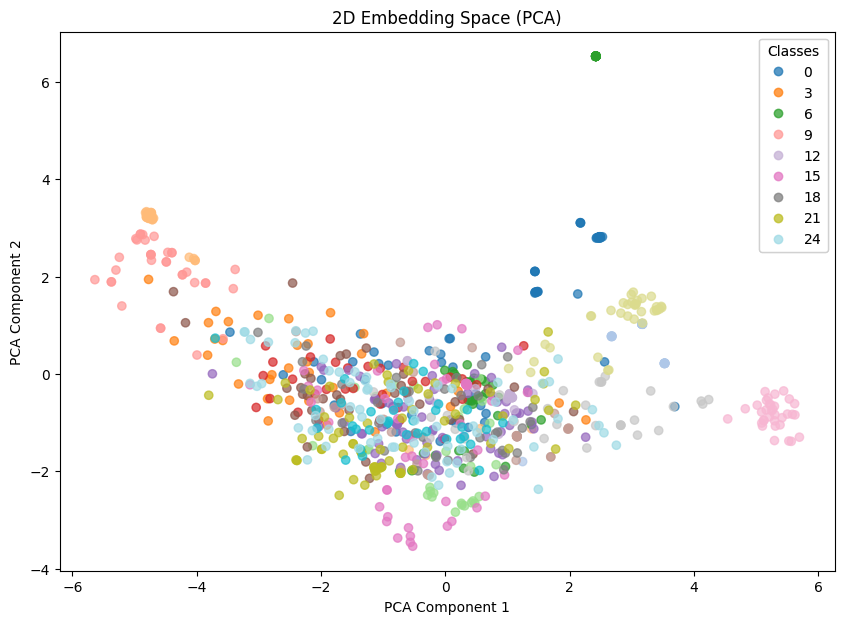

In [14]:
optimizer = torch.torch.optim.SGD([{'params': embedding_model.parameters(), 'lr' : 0.01}] + [{'params' : criterion.parameters(), 'lr' : 0.01}])
print("Starting Main Training V2...")
train_model_with_dynamic_lr(embedding_model, criterion, optimizer, train_loader, 5, DEVICE)

plot_2d_embedding_space(embedding_model, test_loader, n_samples=1000, device = DEVICE)


Average loss on test set: 0.4956
{'Loss': tensor(0.4956), 'Accuracy': 0.6957013607025146, 'Precision': 0.6911635398864746, 'Recall': 0.6957013607025146, 'F1 Score': 0.6892040371894836}


/tmp/ipykernel_48628/2529446955.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted = torch.tensor(predicted).to(device)
/tmp/ipykernel_48628/2529446955.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label).to(device)


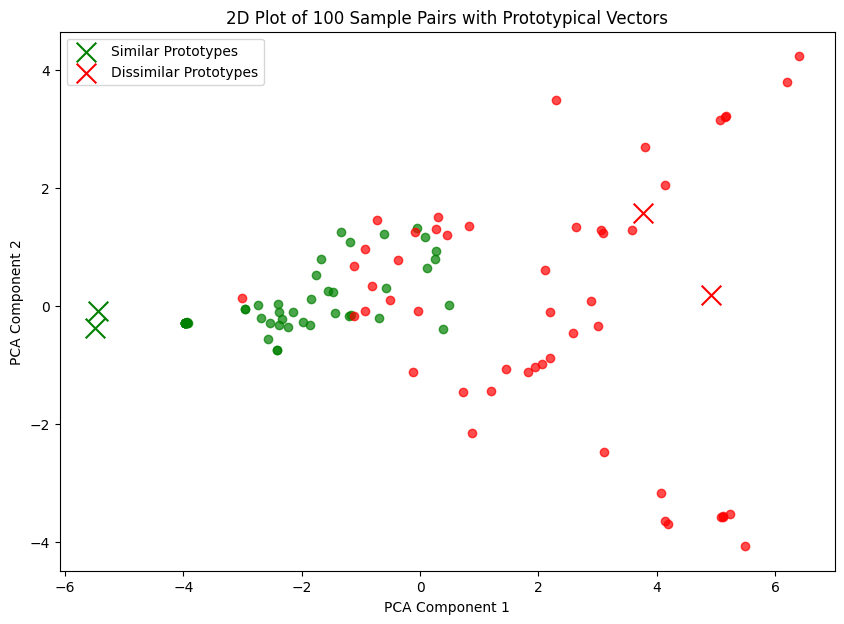

In [15]:
# Evaluate the model with k-NN on the test set
loss, accuracy, precision, recall, f1_score = test(0, embedding_model, criterion, train_loader, test_loader, DEVICE)

# Save results to CSV
results = {
        "Loss": loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
}

print(results)

plot_s_vectors_with_prototypes(embedding_model, criterion, test_loader, n_pairs=100, device = DEVICE)

# Transfer Learning

In [16]:
import torch
import torch.nn as nn
from torchvision import models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Carregar o modelo ResNet18
resnet18 = models.resnet18(pretrained=False, num_classes=NUM_CLASSES)  # Não precisa ser pré-treinado se você tiver os pesos

# Carregar o arquivo de checkpoint
checkpoint = torch.load('../weigths/noise/resnet18_best.pth')

# Ver as chaves dentro do checkpoint
print(checkpoint.keys())

# A chave que contém os pesos pode ser "state_dict"
model_weights = checkpoint['state_dict']

# Verificar as chaves dos pesos para a última camada
print(model_weights['fc.weight'].shape)  # Isso vai retornar o tamanho da camada final

# Aplicar os pesos ao modelo ResNet18
resnet18.load_state_dict(model_weights, strict=False)
#resnet18.load_state_dict(checkpoint)  # load


/home/ivo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ivo/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


dict_keys(['Epoch', 'state_dict', 'optim_dict'])
torch.Size([26, 512])


<All keys matched successfully>

In [17]:
import torch
import torch.nn as nn
from torchvision import models
# Carregar o modelo ResNet18
resnet18 = models.resnet18(pretrained=False, num_classes=NUM_CLASSES)  # Não precisa ser pré-treinado se você tiver os pesos

#checkpoint = torch.load('../../weigths/blur/resnet18_best.pth')
checkpoint = torch.load('../weigths/noise/resnet18_best.pth')

#print(checkpoint.keys())
# Imprimir as chaves do 'state_dict' (os pesos do modelo)
#print("Chaves do state_dict:", checkpoint['state_dict'].keys())

resnet_weights = checkpoint['state_dict']

resnet18.load_state_dict(resnet_weights, strict=False)

mobilenet = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
#mobilenet = models.mobilenet_v2(pretrained=False)
mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Vamos assumir que conseguimos mapear algumas camadas diretamente.
mobilenet_weights = mobilenet.state_dict()

# Para cada camada, você precisaria fazer um mapeamento entre ResNet e MobileNet
for name, param in resnet_weights.items():
    if name in mobilenet_weights:
        # Adapte o nome e a forma das camadas
        mobilenet_weights[name] = param

mobilenet.load_state_dict(mobilenet_weights)

# Faz com que a mobilenet tenha saída igual ao número de classes
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, NUM_CLASSES)
# Verificar a forma do peso da primeira camada convolucional em ambos os modelos
print("ResNet Conv1 weight shape:", resnet_weights['conv1.weight'].shape)
print("MobileNet Conv1 weight shape:", mobilenet_weights['features.0.0.weight'].shape)

input_image = torch.randn(1, 1, 64, 64).to(DEVICE)  # Imagem com 1 canal (escala de cinza)

# Passar a imagem pelo modelo
output = mobilenet(input_image)

# Verificar o formato da saída
print("Output shape:", output.shape)


# Acessar a primeira camada convolucional (features[0])
first_conv_layer = mobilenet.features[0][0]

# Verificar os atributos do peso
print("Número de canais de entrada esperados: ", first_conv_layer.in_channels)
print("Tamanho do kernel da primeira camada convolucional: ", first_conv_layer.kernel_size)

# Criar uma imagem de teste com 1 canal (escala de cinza) e tamanho (1, 64, 64)
input_image = torch.randn(1, 1, 64, 64)  # Batch size = 1, 1 canal, 64x64 pixels

# Passar a imagem pelo modelo
output = mobilenet(input_image)

# Imprimir o tamanho da saída (o que deve ser um vetor com as características do embedding)
print("Saída do MobileNetV2:", output.shape)
print("Tamanho da camada final (classifier[1]):", mobilenet.classifier[1].out_features)
embedding_model = mobilenet.to(DEVICE)

ResNet Conv1 weight shape: torch.Size([64, 3, 7, 7])
MobileNet Conv1 weight shape: torch.Size([32, 1, 3, 3])
Output shape: torch.Size([1, 26])
Número de canais de entrada esperados:  1
Tamanho do kernel da primeira camada convolucional:  (3, 3)
Saída do MobileNetV2: torch.Size([1, 26])
Tamanho da camada final (classifier[1]): 26


In [18]:
embedding_size = 26

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

embedding_model = mobilenet.to(DEVICE)

train_loader, test_loader = get_data_loaders(args['dataset'], args['batch_size'])

'''
Mesmo código de execução no primeiro caso mas com carregamento baseado nos pesos da resnet18
'''

criterion = PrototypicalCenterLoss(num_classes=26, embedding_size=embedding_size, margin=1.0).to(DEVICE)  # 10 classes for FashionMNIST
optimizer_pretrain = torch.optim.Adam(list(embedding_model.parameters()) + list(criterion.parameters()), lr=0.001)
# Pretrain the encoder using prototypical center loss
print("Starting Pretraining with Prototypical Center Loss...")
pretrain_model_prototypical_center(embedding_model, train_loader, criterion, optimizer_pretrain, 10, DEVICE)


Starting Pretraining with Prototypical Center Loss...
Iniciando época 1


Época 1: 100%|███████████████████████████████| 13/13 [00:22<00:00,  1.75s/batch]


Pretrain Epoch [1/10], Loss: 20.2996
Iniciando época 2


Época 2: 100%|███████████████████████████████| 13/13 [00:22<00:00,  1.74s/batch]


Pretrain Epoch [2/10], Loss: 10.4692
Iniciando época 3


Época 3: 100%|███████████████████████████████| 13/13 [00:22<00:00,  1.74s/batch]


Pretrain Epoch [3/10], Loss: 6.7687
Iniciando época 4


Época 4: 100%|███████████████████████████████| 13/13 [00:23<00:00,  1.81s/batch]


Pretrain Epoch [4/10], Loss: 5.7161
Iniciando época 5


Época 5: 100%|███████████████████████████████| 13/13 [00:19<00:00,  1.48s/batch]


Pretrain Epoch [5/10], Loss: 5.0368
Iniciando época 6


Época 6: 100%|███████████████████████████████| 13/13 [00:24<00:00,  1.89s/batch]


Pretrain Epoch [6/10], Loss: 4.1924
Iniciando época 7


Época 7: 100%|███████████████████████████████| 13/13 [00:16<00:00,  1.27s/batch]


Pretrain Epoch [7/10], Loss: 3.0612
Iniciando época 8


Época 8: 100%|███████████████████████████████| 13/13 [00:15<00:00,  1.21s/batch]


Pretrain Epoch [8/10], Loss: 2.5131
Iniciando época 9


Época 9: 100%|███████████████████████████████| 13/13 [00:15<00:00,  1.23s/batch]


Pretrain Epoch [9/10], Loss: 2.0787
Iniciando época 10


Época 10: 100%|██████████████████████████████| 13/13 [00:15<00:00,  1.19s/batch]

Pretrain Epoch [10/10], Loss: 1.6304


In [19]:
criterion = LearnablePrototypicalLossWithDiversityRegularization(embedding_dim=embedding_size,
                                                  num_similar_prototypes=2,
                                                  num_dissimilar_prototypes=2).to(DEVICE)

optimizer = torch.optim.Adam(list(criterion.parameters()), lr=0.01)
# Train with dynamic learning rate
print("Starting Main Training...")
train_model_with_dynamic_lr(embedding_model, criterion, optimizer, train_loader, 15, DEVICE, frozen = True)


Starting Main Training...


Época 1: 100%|███████████████████████████████| 13/13 [00:16<00:00,  1.24s/batch]


Epoch [1/15], Loss: 0.3439, LR: 0.010000


Época 2: 100%|███████████████████████████████| 13/13 [00:24<00:00,  1.92s/batch]


Epoch [2/15], Loss: 0.3103, LR: 0.010000


Época 3: 100%|███████████████████████████████| 13/13 [00:14<00:00,  1.15s/batch]


Epoch [3/15], Loss: 0.2839, LR: 0.010000


Época 4: 100%|███████████████████████████████| 13/13 [00:14<00:00,  1.10s/batch]


Epoch [4/15], Loss: 0.2699, LR: 0.010000


Época 5: 100%|███████████████████████████████| 13/13 [00:13<00:00,  1.06s/batch]


Epoch [5/15], Loss: 0.2472, LR: 0.010000


Época 6: 100%|███████████████████████████████| 13/13 [00:15<00:00,  1.20s/batch]


Epoch [6/15], Loss: 0.2365, LR: 0.010000


Época 7: 100%|███████████████████████████████| 13/13 [00:14<00:00,  1.11s/batch]


Epoch [7/15], Loss: 0.2261, LR: 0.010000


Época 8: 100%|███████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch [8/15], Loss: 0.2252, LR: 0.010000


Época 9: 100%|███████████████████████████████| 13/13 [00:16<00:00,  1.26s/batch]


Epoch [9/15], Loss: 0.2169, LR: 0.010000


Época 10: 100%|██████████████████████████████| 13/13 [00:14<00:00,  1.12s/batch]


Epoch [10/15], Loss: 0.2054, LR: 0.009000


Época 11: 100%|██████████████████████████████| 13/13 [00:13<00:00,  1.07s/batch]


Epoch [11/15], Loss: 0.2107, LR: 0.009000


Época 12: 100%|██████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch [12/15], Loss: 0.2148, LR: 0.009000


Época 13: 100%|██████████████████████████████| 13/13 [00:13<00:00,  1.04s/batch]


Epoch [13/15], Loss: 0.2014, LR: 0.009000


Época 14: 100%|██████████████████████████████| 13/13 [00:13<00:00,  1.08s/batch]


Epoch [14/15], Loss: 0.1971, LR: 0.009000


Época 15: 100%|██████████████████████████████| 13/13 [00:13<00:00,  1.05s/batch]

Epoch [15/15], Loss: 0.1976, LR: 0.009000


In [ ]:
optimizer = torch.torch.optim.SGD([{'params': embedding_model.parameters(), 'lr' : 0.01}] + [{'params' : criterion.parameters(), 'lr' : 0.01}])
print("Starting Main Training V2...")
train_model_with_dynamic_lr(embedding_model, criterion, optimizer, train_loader, 10, DEVICE)

plot_2d_embedding_space(embedding_model, test_loader, n_samples=1000, device = DEVICE)

Starting Main Training V2...


Época 1: 100%|███████████████████████████████| 13/13 [00:48<00:00,  3.73s/batch]


Epoch [1/10], Loss: 0.1907, LR: 0.010000


Época 2: 100%|███████████████████████████████| 13/13 [00:44<00:00,  3.46s/batch]


Epoch [2/10], Loss: 0.1904, LR: 0.010000


Época 3: 100%|███████████████████████████████| 13/13 [00:49<00:00,  3.78s/batch]


Epoch [3/10], Loss: 0.1895, LR: 0.010000


Época 4: 100%|███████████████████████████████| 13/13 [00:45<00:00,  3.52s/batch]


Epoch [4/10], Loss: 0.1897, LR: 0.010000


Época 5: 100%|███████████████████████████████| 13/13 [00:43<00:00,  3.37s/batch]


Epoch [5/10], Loss: 0.1913, LR: 0.010000


Época 6: 100%|███████████████████████████████| 13/13 [00:43<00:00,  3.38s/batch]


Epoch [6/10], Loss: 0.1914, LR: 0.010000


Época 7: 100%|███████████████████████████████| 13/13 [00:47<00:00,  3.66s/batch]


Epoch [7/10], Loss: 0.1891, LR: 0.010000


Época 8: 100%|███████████████████████████████| 13/13 [00:48<00:00,  3.72s/batch]


Epoch [8/10], Loss: 0.1884, LR: 0.010000


Época 9:   8%|██▍                             | 1/13 [00:04<00:52,  4.40s/batch]

In [ ]:
# Evaluate the model with k-NN on the test set
loss, accuracy, precision, recall, f1_score = test(0, embedding_model, criterion, train_loader, test_loader, DEVICE)

# Save results to CSV
results = {
        "Loss": loss,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
}

print(results)

plot_s_vectors_with_prototypes(embedding_model, criterion, test_loader, n_pairs=100, device = DEVICE)